In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from scipy import stats

In [20]:
def get_color_list(cmap, n):
    
    values = np.linspace(0, 1, n)
    colors = cmap(values)
    colors = [color[:3] for color in colors]
    return colors

In [21]:
get_color_list(plt.cm.RdPu_r, n=10)

[array([0.28627451, 0.        , 0.41568627]),
 array([0.45507113, 0.00344483, 0.46046905]),
 array([0.63277201, 0.00392157, 0.48744329]),
 array([0.80522876, 0.1372549 , 0.55947712]),
 array([0.92224529, 0.31507882, 0.61353326]),
 array([0.97397924, 0.50595925, 0.66705113]),
 array([0.98300654, 0.67320261, 0.72418301]),
 array([0.98918877, 0.79829296, 0.78059208]),
 array([0.99311034, 0.88939639, 0.87715494]),
 array([1.        , 0.96862745, 0.95294118])]

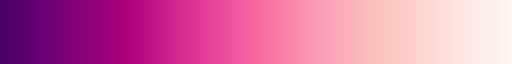

In [22]:
plt.cm.RdPu_r

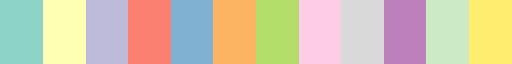

In [23]:
plt.cm.Set3

In [24]:
df = pd.read_excel("data/1832_v4.xlsx", index_col=0)
jobs = pd.read_excel("data/histoire urbaine digitale classification metiers.xlsx", na_values="?", sheet_name="data")

In [25]:
df = df[[
    "nom_rue_norm_2",
    "no_maison",
    "proprietaire_nom_norm_2",
    "chef_prenom_norm",
    "chef_nom_norm_2",
    "chef_annee_naissance",
    "epouse_nom_norm",
    "epouse_annee_naissance",
    "enfants_dans_la_commune_prenom_norm",
    "enfants_annee_naissance",
    "chef_origine_norm_2",
    "chef_annee_arrivee",
    "chef_vocation_norm_2",
    "pensionnaires_prenom_norm",
    "pensionnaires_nom_norm",
    "pensionnaires_origine_norm",
    "Page"
]]

In [26]:
# remove "_norm_2" from all column names
df.columns = [re.sub("_norm_2", "", col) for col in df.columns]
# remove "_norm" from all column names
df.columns = [re.sub("_norm", "", col) for col in df.columns]

In [27]:
df.columns

Index(['nom_rue', 'no_maison', 'proprietaire_nom', 'chef_prenom', 'chef_nom',
       'chef_annee_naissance', 'epouse_nom', 'epouse_annee_naissance',
       'enfants_dans_la_commune_prenom', 'enfants_annee_naissance',
       'chef_origine', 'chef_annee_arrivee', 'chef_vocation',
       'pensionnaires_prenom', 'pensionnaires_nom', 'pensionnaires_origine',
       'Page'],
      dtype='object')

In [28]:
jobs.head(10)

,JOB,CLASS
0,rentier?,rente
1,rentiere,rente
2,journalier,agricole
3,vigneron,agricole
4,proprietaire,rente
5,rentier,rente
6,cordonnier,artisanat
7,menuisier,artisanat/construction
8,journaliere,agricole
9,charpentier,construction


In [29]:
df["chef_vocation"]

1                 charon
2       marechal-ferrant
3                lingere
4                rentier
5       garcon voiturier
              ...       
3697         agriculteur
3698          journalier
3699         agriculteur
3700         agriculteur
3701            fruitier
Name: chef_vocation, Length: 3674, dtype: object

In [30]:
# Join df and jobs with chef_vocation in df and JOB in jobs
df = df.join(jobs.set_index("JOB"), on="chef_vocation", how="left")
# rename the CLASS column as chef_vocation_class
df = df.rename(columns={"CLASS": "chef_vocation_class"})

In [31]:
df[["chef_vocation", "chef_vocation_class"]]

,chef_vocation,chef_vocation_class
1,charon,NaN
2,marechal-ferrant,artisanat
3,lingere,service
4,rentier,rente
5,garcon voiturier,NaN
...,...,...
3697,agriculteur,agricole
3698,journalier,agricole
3699,agriculteur,agricole
3700,agriculteur,agricole


In [32]:
jobs[jobs.JOB == "ministre"]

,JOB,CLASS
40,ministre,administration


In [33]:
df.chef_vocation_class.unique()

array([nan, 'artisanat', 'service', 'rente', 'commerce',
       'artisanat/service', 'agricole', 'construction',
       'artisanat/construction', 'administration',
       'construction/artisanat', 'service/construction',
       'service/artisanat'], dtype=object)

In [34]:
df.columns

Index(['nom_rue', 'no_maison', 'proprietaire_nom', 'chef_prenom', 'chef_nom',
       'chef_annee_naissance', 'epouse_nom', 'epouse_annee_naissance',
       'enfants_dans_la_commune_prenom', 'enfants_annee_naissance',
       'chef_origine', 'chef_annee_arrivee', 'chef_vocation',
       'pensionnaires_prenom', 'pensionnaires_nom', 'pensionnaires_origine',
       'Page', 'chef_vocation_class'],
      dtype='object')

In [35]:
df.shape

(3674, 18)

In [36]:
df.chef_origine.shape

(3674,)

In [62]:
origins = df.groupby("chef_origine").size().sort_values(ascending=False)
origins.head()

chef_origine
lausanne                 622
·                        126
lutry                    102
corporation francaise     73
epalinges                 68
dtype: int64

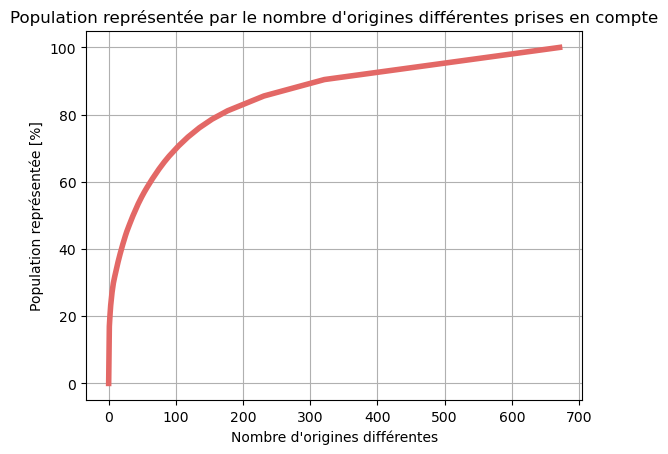

In [72]:
# Get the percentage of the population that is represented by the top 10 origins and plot it as a graph in terms of x
origins.head(10).sum() / origins.sum()
percentages = [origins.head(x).sum() / origins.sum() for x in range(0, len(origins))]
# Plot the above as a line
plt.title("Population représentée par le nombre d'origines différentes prises en compte")
plt.xlabel("Nombre d'origines différentes")
plt.ylabel("Population représentée [%]")
plt.grid(visible=True, which="both")
plt.plot(np.asarray(percentages) * 100,'-',color="#e36866",linewidth=4)

<AxesSubplot:ylabel='None'>

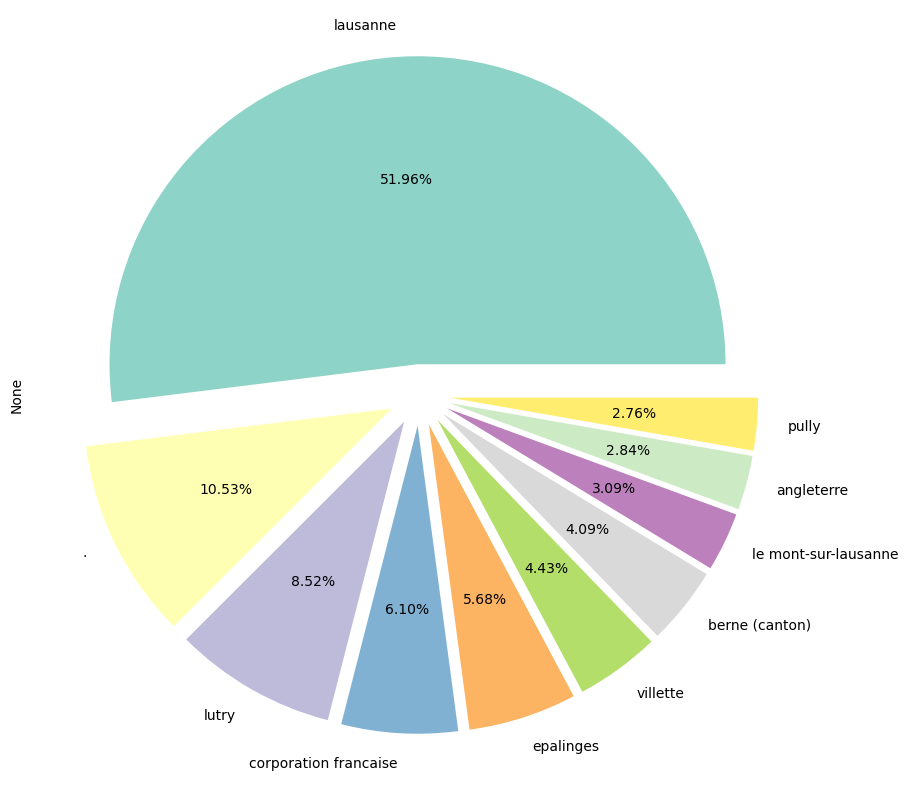

In [60]:
origins = df.groupby("chef_origine").size().sort_values(ascending=False)
origins_with_others = pd.concat([origins[:10], pd.Series(origins[10:].sum(), index=["Autres"])])
# plot the top 10 origins as a pie chart and make the pieces detached from the center
origins[:10].plot.pie(figsize=(10, 10), autopct="%.2f%%", cmap=plt.cm.Set3 , explode=[0.1] * 10)

In [25]:
df_new = df[df.chef_annee_naissance.str.len() == 4]
df_new = df_new[df_new.chef_annee_naissance.str.isnumeric()]
df_new.chef_annee_naissance = df_new.chef_annee_naissance.astype(int)

In [26]:
df_new.shape[0] / df.shape[0]

0.7939575394665215

In [27]:
df_new.describe()

,chef_annee_naissance,Page
count,2917.000000,2917.000000
mean,1787.910525,75.427151
std,127.003629,41.505349
min,1264.000000,1.000000
25%,1776.000000,42.000000
50%,1787.000000,77.000000
75%,1798.000000,109.000000
max,7771.000000,151.000000


Remove all people that are negative or less than $0$ years old and people that are more than $100$ years old.

In [28]:
df_new = df_new[(df_new.chef_annee_naissance < 1832) & (df_new.chef_annee_naissance >= 1700)]
print(f"Ratio of values that we keep {df_new.shape[0] / df.shape[0]:%}, number of values that we keep is {df_new.shape[0]}.")

Ratio of values that we keep 78.606424%, number of values that we keep is 2888.


In [29]:
# Bootstrap the mean of the chef_annee_naissance column with 10_000 samples
means = []
for i in range(10_000):
    sample = df_new.chef_annee_naissance.sample(frac=1, replace=True)
    means.append(sample.mean())

In [30]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])

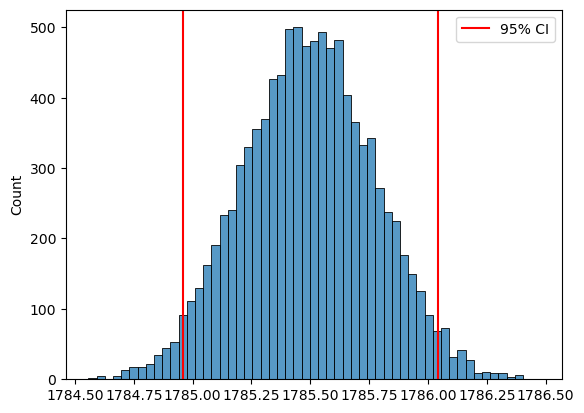

In [31]:
# plot the means with the 95% confidence interval
plt.title
sns.histplot(means)
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.show()

In [32]:
df_new.chef_annee_naissance.mean()# - ci[0], df_new.chef_annee_naissance.mean() - ci[1]

1785.4954986149585

In [35]:
# Bootstrap the mean of the chef_annee_naissance that have "administration" as chef_vocation_class with 10_000 samples
means_administration = []
for i in range(10_000):
    sample = df_new[df_new.chef_vocation_class == "administration"].chef_annee_naissance.sample(frac=1, replace=True)
    means_administration.append(sample.mean())
    
# Bootstrap the mean of the chef_annee_naissance that have "construction" as chef_vocation_class with 10_000 samples
means_construction = []
for i in range(10_000):
    sample = df_new[df_new.chef_vocation_class == "construction"].chef_annee_naissance.sample(frac=1, replace=True)
    means_construction.append(sample.mean())

<AxesSubplot:ylabel='Count'>

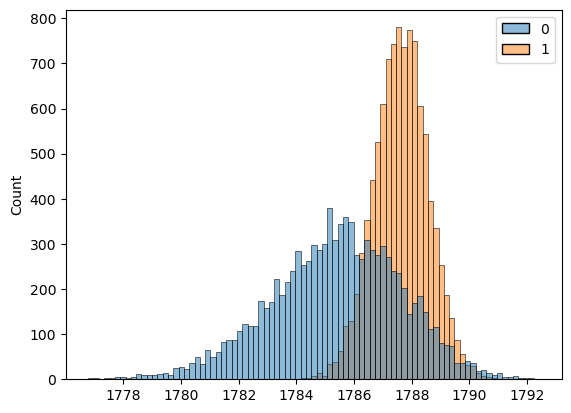

In [42]:
sns.histplot([means_administration, means_construction])

<AxesSubplot:xlabel='chef_annee_naissance', ylabel='Count'>

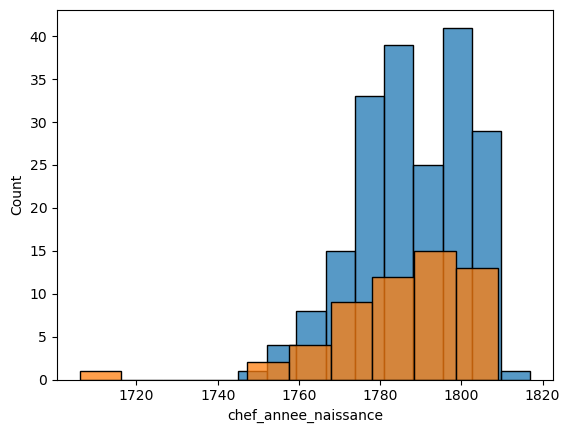

In [56]:
sns.histplot(df_new[df_new.chef_vocation_class == "construction"].chef_annee_naissance, label="construction")
sns.histplot(df_new[df_new.chef_vocation_class == "administration"].chef_annee_naissance, label="administration")

In [34]:
(1832 - df_new[df_new.chef_vocation_class == "administration"].chef_annee_naissance.mean(), 1832 - df_new[df_new.chef_vocation_class == "construction"].chef_annee_naissance.mean())

(46.60714285714289, 44.37755102040819)

In [11]:
df_new

,nom_rue,no_maison,proprietaire_nom,chef_prenom,chef_nom,chef_annee_naissance,epouse_nom,epouse_annee_naissance,enfants_dans_la_commune_prenom,enfants_annee_naissance,...,chef_annee_arrivee,chef_vocation,chef_recepisse,pensionnaires_prenom,pensionnaires_nom,pensionnaires_origine,pensionnaires_condition,pensionnaires_recepisse,observations,Page
1,martheray,1,veidmann,george,de naisse|veidmann,1764,·,·,·,·,...,1786,charon,844,louise|anna|francois|jn adam,veidmann|la maurer|kirsner|reverber,tolochenaz|frutigen|cirol|bavarois,petite fille naturelle|dom|macon|ouvrier charron,12879|10913|16222,de barhara taidman nee,1
3,martheray,3,fiaux,louise,piot,1785,neissance,·,benjamin,1815,...,nee,lingere,2272,·,·,·,·,·,·,1
5,martheray,·,·,louis vincent,lavanchy,1802,baud,1805,·,·,...,ne,garcon viturier,4462,·,·,·,·,·,·,1
7,martheray,·,·,dominique,dubois,1797,·,·,·,·,...,1828,abenitte|no de,1490,adolphine cecile|adolphine,borrely|borrely,paris|enfant de la che,lingere|dite nee en o,489,·,1
8,martheray,·,·,francois,piaux,1787,blaud,·,felix|charles|ernestine,1826|·|1822,...,ne,rentier,·,rose marie,metraux,pailly,domest,3370,·,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697,no de leurs,·,·,jn abram,martin,1804,francoise,1804,henry|david,1829|1830,...,·,atif,·,·,·,·,·,·,·,150
3698,montherond,·,jacob martin,jean abram,blanc,1806,marie,1807,charles elie|louis jules,1829|1831,...,1830,journallier,·,·,·,·,·,·,·,151
3699,sangalles,·,commune de t|lausanne,veuve,culler,1810,·,neene,jn louise|lse susanne|jean marc|jaques|ct fran...,1800|1803|1806|1808|1809|1812|1814,...,1820,agriculteur,922,·,·,·,·,·,·,151
3700,chalet aux cenfans,·,md aubergiste,david,abeiden,1771,francoise,1773,·,·,...,·,agriculteur,612,·,·,·,·,·,·,151


In [12]:
df_new.describe()

,chef_annee_naissance,Page
count,2877.000000,2877.000000
mean,1785.818561,75.569343
std,14.055069,41.524744
min,1741.000000,1.000000
25%,1776.000000,42.000000
50%,1787.000000,77.000000
75%,1797.000000,109.000000
max,1824.000000,151.000000


In [13]:
df_new[df_new.chef_annee_naissance == 1824]

,nom_rue,no_maison,proprietaire_nom,chef_prenom,chef_nom,chef_annee_naissance,epouse_nom,epouse_annee_naissance,enfants_dans_la_commune_prenom,enfants_annee_naissance,...,chef_annee_arrivee,chef_vocation,chef_recepisse,pensionnaires_prenom,pensionnaires_nom,pensionnaires_origine,pensionnaires_condition,pensionnaires_recepisse,observations,Page
563,saux,·,·,jean david,martin,1824,coulin,1804,francois|emanuel,1828|1830,...,·,tanneur,3185,louise,maillari,perey,pensionnaire,4850,·,22


Find the proprietary that comes up the most frequently.

In [14]:
df_new.groupby("proprietaire_nom").size().sort_values(ascending=False)

proprietaire_nom
·            1748
blanc          27
iio            13
rouge          12
chapuis        12
             ... 
fischer         1
forneret        1
fraisse         1
franallon       1
·|nos           1
Length: 735, dtype: int64

Number of children:

In [15]:
def count_children(s: str) -> int:
    if s == '·' or s == '.':
        return 0
    return s.count("|") + 1

df_new["nb_enfants"] = df_new.enfants_dans_la_commune_prenom.apply(count_children)

In [16]:
df_new.describe()

,chef_annee_naissance,Page,nb_enfants
count,2877.000000,2877.000000,2877.000000
mean,1785.818561,75.569343,1.534932
std,14.055069,41.524744,1.698168
min,1741.000000,1.000000,0.000000
25%,1776.000000,42.000000,0.000000
50%,1787.000000,77.000000,1.000000
75%,1797.000000,109.000000,2.000000
max,1824.000000,151.000000,10.000000


<AxesSubplot:title={'center':'Distribution des années de naissance du chef'}, xlabel='chef_annee_naissance', ylabel='Count'>

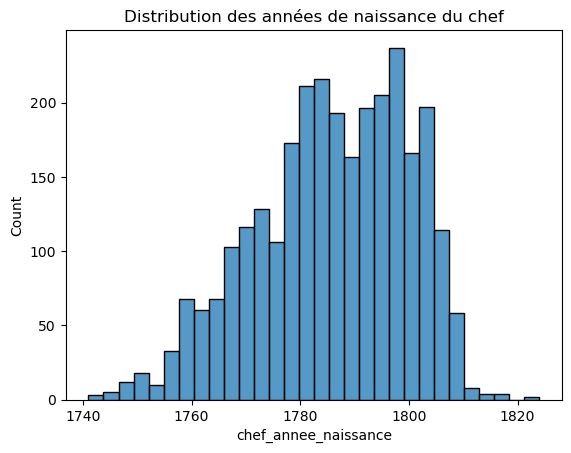

In [25]:
plt.title("Distribution des années de naissance du chef")
sns.histplot(data=df_new, x="chef_annee_naissance", bins=30)

<AxesSubplot:title={'center':"Distribution du nombre d'enfants"}, xlabel='nb_enfants', ylabel='Count'>

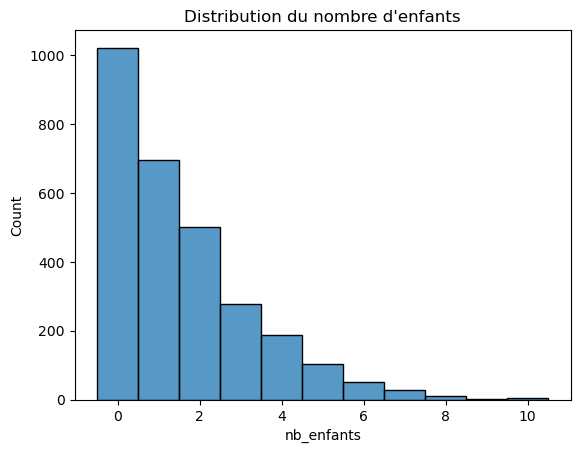

In [18]:
plt.title("Distribution du nombre d'enfants")
sns.histplot(data=df_new, x="nb_enfants", discrete=True)

In [37]:
import statsmodels.api as sm
import scipy

In [68]:
sm.qqplot(df_new.nb_enfants, line='45', dist=scipy.stats.poisson.stats, distargs=5)

TypeError: 'int' object is not iterable